In [160]:
import cv2
import torch
import torchvision
import numpy as np
import copy
import random
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchvision.io.image import read_image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# print(torchvision.__version__)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


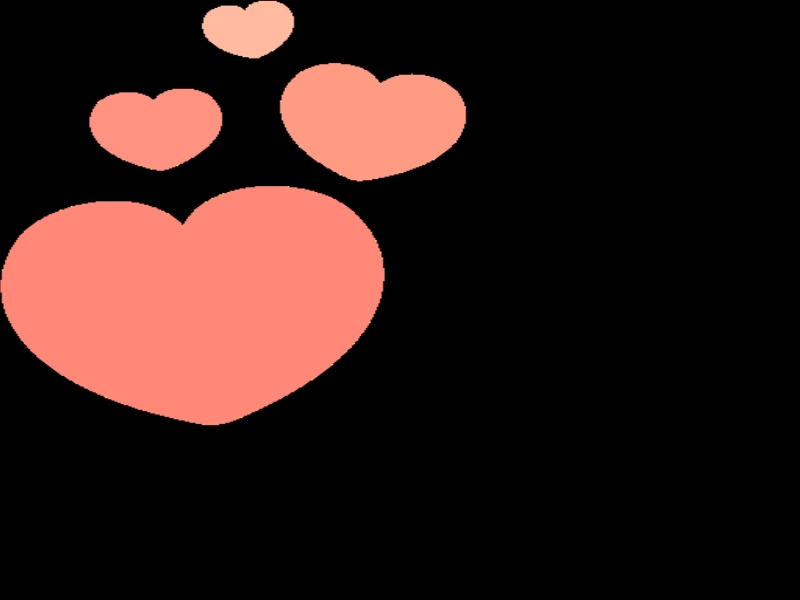

In [161]:
test_img1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q1.jpg", cv2.IMREAD_COLOR)
test_img1 = cv2.resize(test_img1, (800, 600))
test_img2 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q2.jpg", cv2.IMREAD_COLOR)
test_img2 = cv2.resize(test_img2, (800, 600))
test_img3 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q5.jpg", cv2.IMREAD_COLOR)
test_img3 = cv2.resize(test_img3, (800, 600))
test_img4 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q6.jpg", cv2.IMREAD_COLOR)
test_img4 = cv2.resize(test_img4, (800, 600))
heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart.jpg", cv2.IMREAD_COLOR)
heart_img = cv2.resize(heart_img, (800, 600))
cv2_imshow(heart_img)

In [162]:
input_data = np.array([test_img1,test_img2, test_img3, test_img4])
height, width = input_data[0].shape[:2]
img_size = height * width

In [163]:
for i in range(input_data.shape[0]):
    cv2_imshow(input_data[i])

Output hidden; open in https://colab.research.google.com to view.

In [164]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()

model = maskrcnn_resnet50_fpn(weights=weights)
model = model.eval()

In [165]:
input_img_list = []
tt = torchvision.transforms.ToTensor()

for i in range(input_data.shape[0]):
    input_img_list.append(tt(input_data[i]))

In [166]:
def make_mask(outputs):
    img_num = len(outputs)
    tmp_dic = {}
    prior_label = [1, 17, 18, 52, 53, 54, 55, 59, 60, 61, 84, 88]
    del_list = []
    real_dic = {}
    score_dic = {}
    proportion = 0.1
    proba_threshold = 0.5
    mask_img = []
    

    for i in prior_label:
      real_dic[i] = -1

    
    # boxes 버리고 각 이미지에서 레이블 중복되는 거 버림
    for i in range(img_num):
        # del outputs[i]["boxes"]   #####################
        outputs[i]["labels"] = outputs[i]["labels"].detach().numpy()
        outputs[i]["scores"] = outputs[i]["scores"].detach().numpy()
        outputs[i]["masks"] = torch.squeeze(outputs[i]["masks"], 1)
        outputs[i]["masks"] = outputs[i]["masks"].detach().numpy()
        del_idx = []

        for j in range(1, len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in outputs[i]["labels"][:j]:
                del_idx.append(j)

        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)

        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], -1)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)


    # tmp_dic에 레이블당 score가 가장 높은 애들을 저장
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] not in tmp_dic:
                tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]
            else:
                if outputs[i]["scores"][j] > tmp_dic[outputs[i]["labels"][j]]:
                    tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]


    # 레이블당 score가 가장 높은 애들을 제외하고 나머지는 삭제
    for i in range(img_num):
        del_idx = []
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in tmp_dic.keys():
                if tmp_dic[outputs[i]["labels"][j]] != outputs[i]["scores"][j]:
                    del_idx.append(j)
        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)
        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], height, width)

    
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in real_dic.keys():
                real_dic[outputs[i]["labels"][j]] = i
            else:
                outputs[i]["masks"][j] = np.where(outputs[i]["masks"][j] < proba_threshold, 0, outputs[i]["masks"][j])
                nonzero_cnt = np.count_nonzero(outputs[i]["masks"][j])
                
                if nonzero_cnt / img_size >= proportion:
                    score_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]


    for i in real_dic.keys():
        if real_dic[i] == -1:
            del_list.append(i)

    for i in del_list:
        del real_dic[i]

    del_list = []

    score_dic = dict(sorted(score_dic.items(), key=lambda x: x[1], reverse=True))

    for i in score_dic.keys():
        if score_dic[i] < 0.5:
            del_list.append(i)

    for i in del_list:
        del score_dic[i]
    
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in score_dic.keys():
                score_dic[outputs[i]["labels"][j]] = i

    real_dic.update(score_dic)


    # while len(real_dic.keys()) != 6:
    #     if len(real_dic.keys()) > 6:
    #         del real_dic[list(real_dic.keys())[-1]]
    #     elif len(real_dic.keys()) < 6:
    #         if len(score_dic.keys()) >= 1:
    #             real_dic[list(score_dic.keys())[0]] = score_dic[list(score_dic.keys())[0]]
    #             del score_dic[list(score_dic.keys())[0]]
    #         else:
    #             break


    while len(real_dic.keys()) > 8:
        del real_dic[list(real_dic.keys())[-1]]


    # outputs에서 사용할 label, score, mask 빼고 다 삭제
    for i in range(img_num):
        del outputs[i]["scores"]
        del_idx = []

        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] not in real_dic.keys():
                del_idx.append(j)

        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)

    tmp_l = list(real_dic.values())

    while len(mask_img) != len(real_dic.keys()):
        for i in range(img_num):
            if i == tmp_l[0]:
                outputs[i]["masks"][0] = np.where(outputs[i]["masks"][0] < 0.25, 0, 255)
                dst = input_data[i].copy()
                dst = cv2.bitwise_and(dst, dst, mask=outputs[i]["masks"][0].astype("uint8"))
                mask_img.append(dst)
                tmp_l.pop(0)
                break

        outputs[i]["masks"] = np.delete(outputs[i]["masks"], 0, axis=0)
        # if len(mask_img) == len(real_dic.keys()):
        #     return real_dic, mask_img   # real_dic 삭제하기
    
    return real_dic, mask_img   # real_dic 삭제하기

In [290]:
torch_img_list = [transform(tmp) for tmp in input_img_list]

outputs = model(torch_img_list)

In [291]:
real_dic, mask_img = make_mask(outputs)

In [292]:
print(real_dic)

{1: 2, 17: 2, 18: 0, 52: 3, 61: 3, 2: 0, 19: 2}


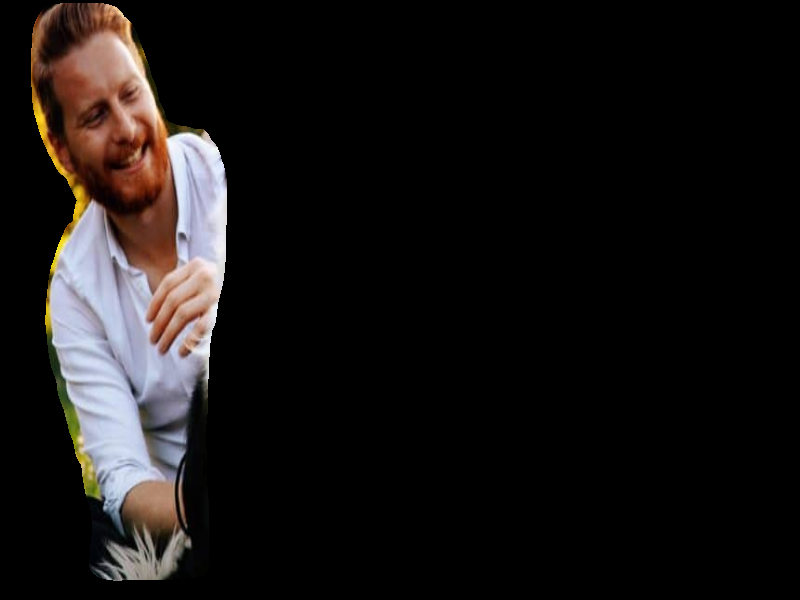

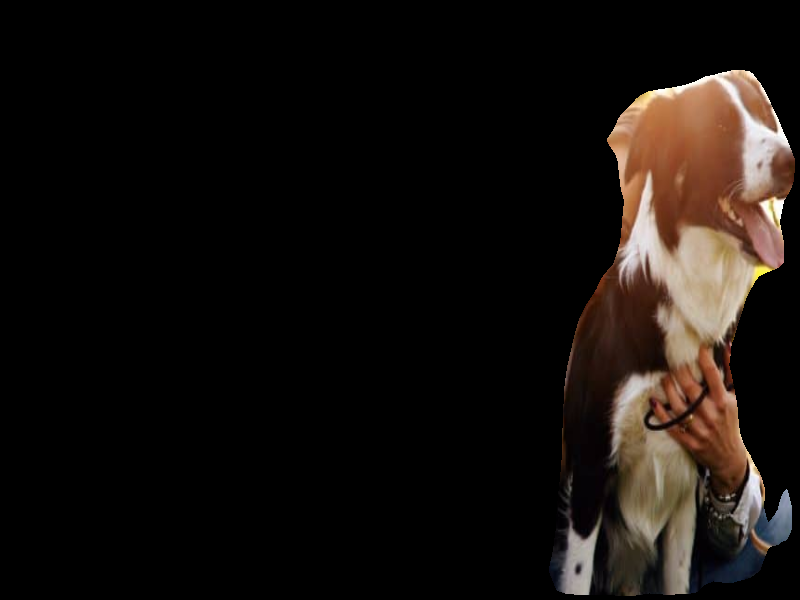

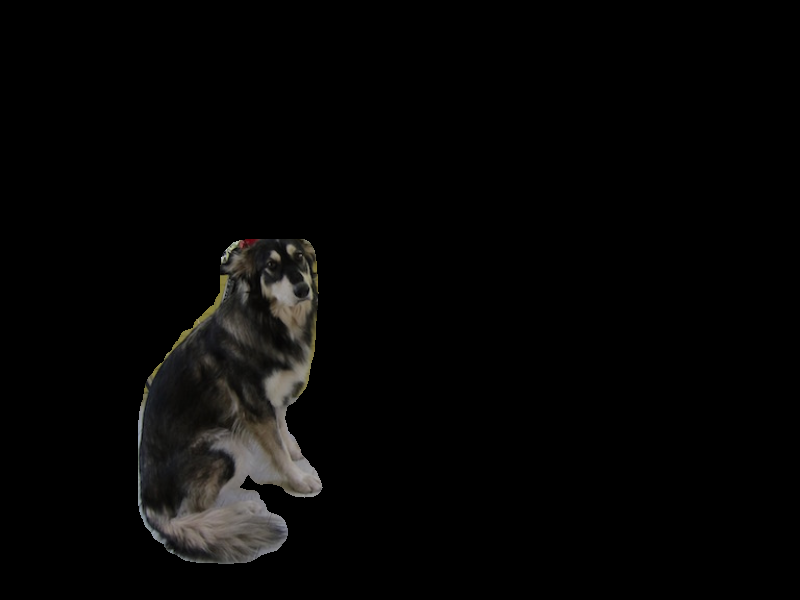

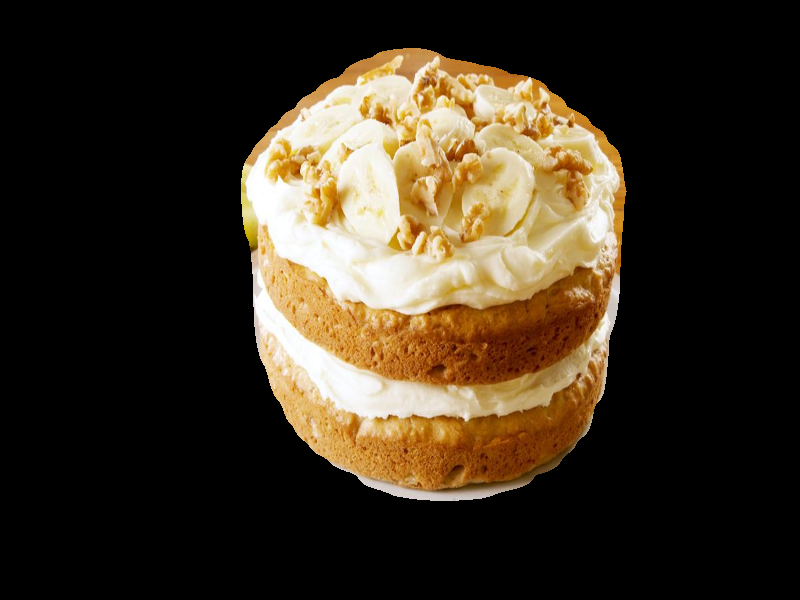

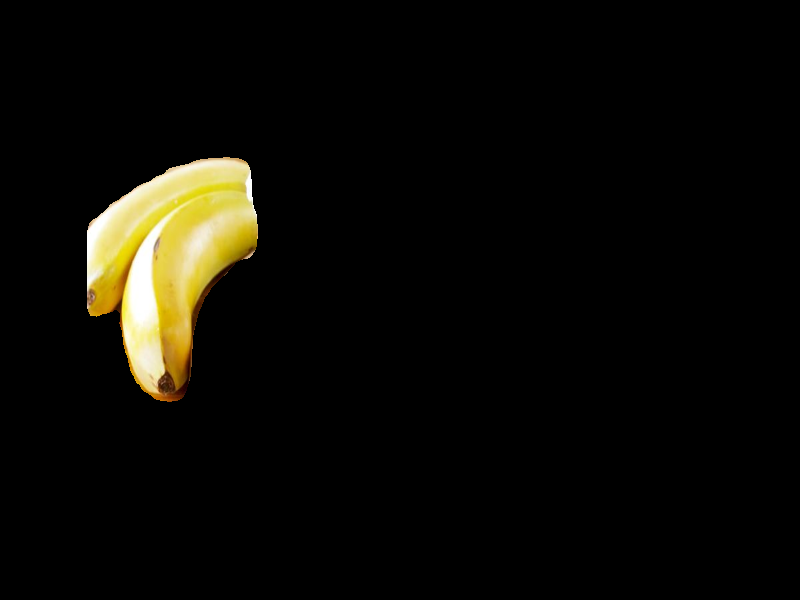

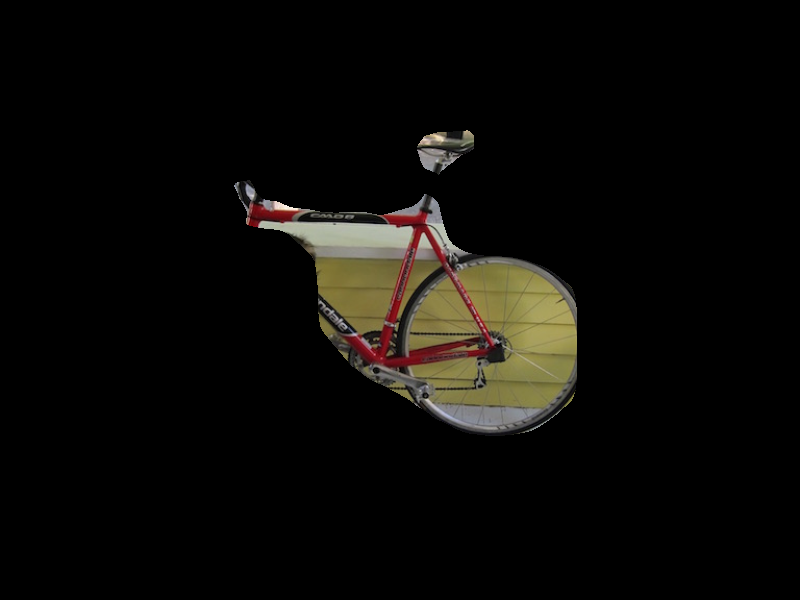

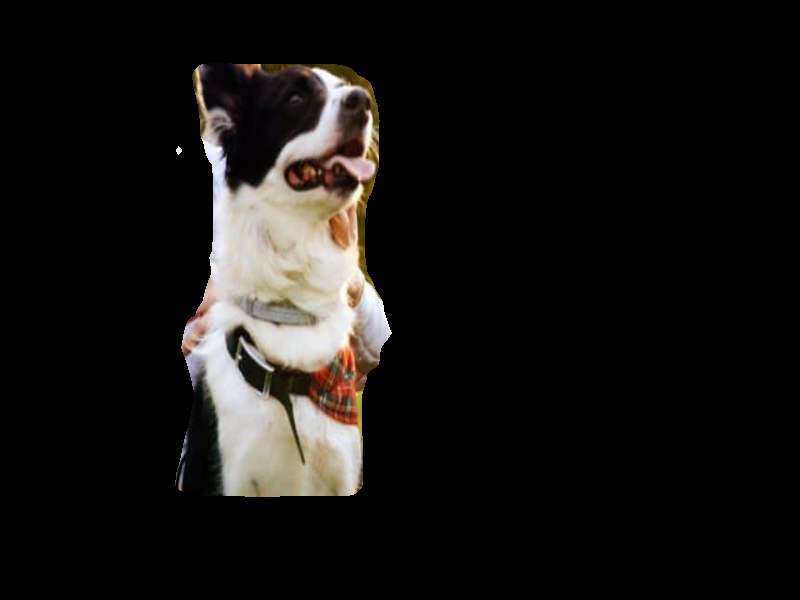

In [293]:
for i in mask_img:
    cv2_imshow(i)
    print()

In [294]:
img_list = []
mask_img_copy = mask_img

for i in range(len(mask_img)):
    tmp = cv2.cvtColor(mask_img[i], cv2.COLOR_BGR2GRAY)
    _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

    for j in range(1, cnt):
        (x, y, w, h, area) = stats[j]

        if area / img_size < 1 / 100:
            tmp[y:y+h, x:x+w] = 0
        
    a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(mask_img_copy[i], a, -1, (255, 255, 255), 11)

    tmp = cv2.bitwise_and(mask_img_copy[i], mask_img_copy[i], mask=tmp)
    img_list.append(tmp)

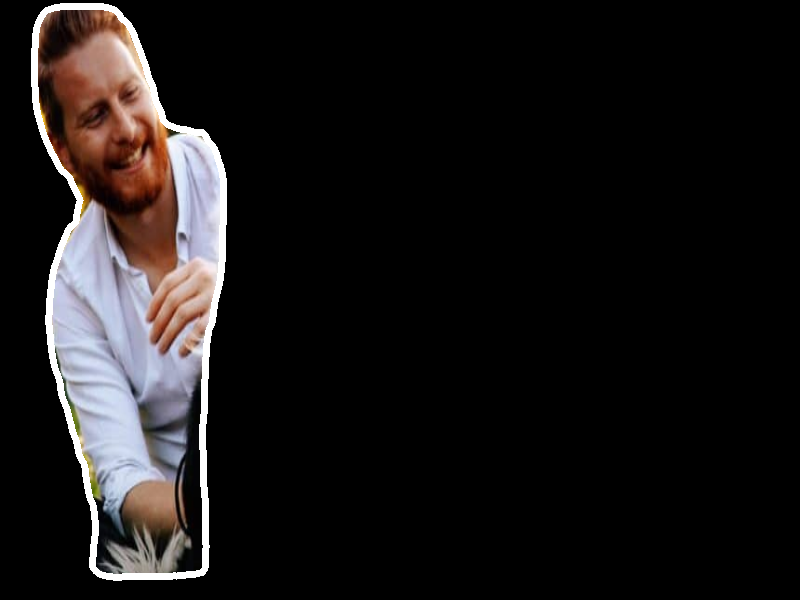

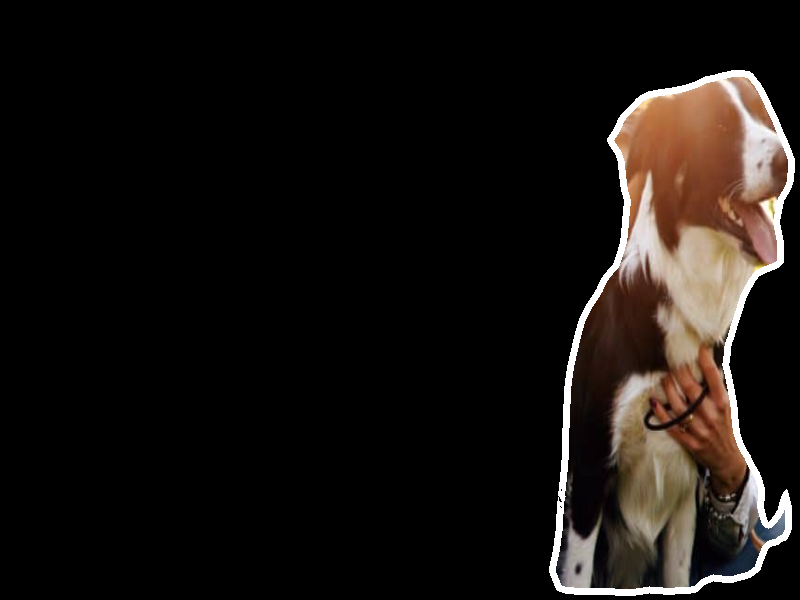

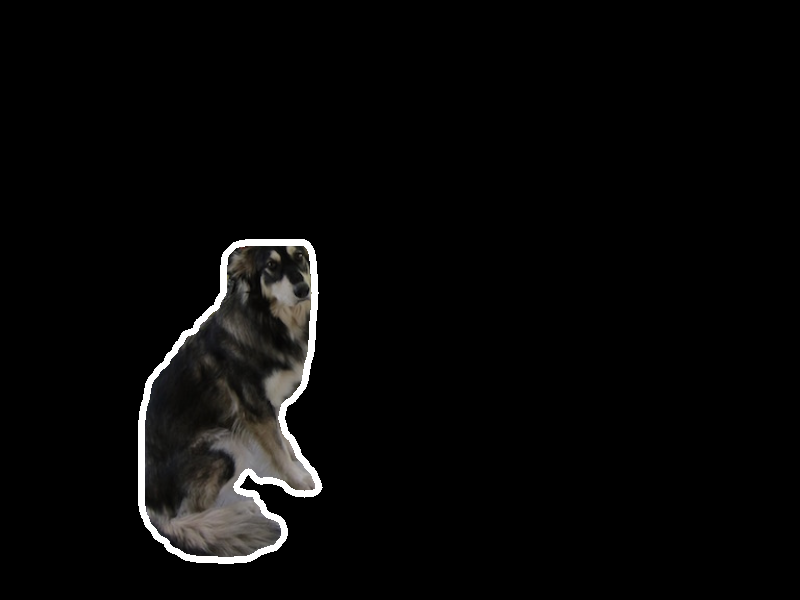

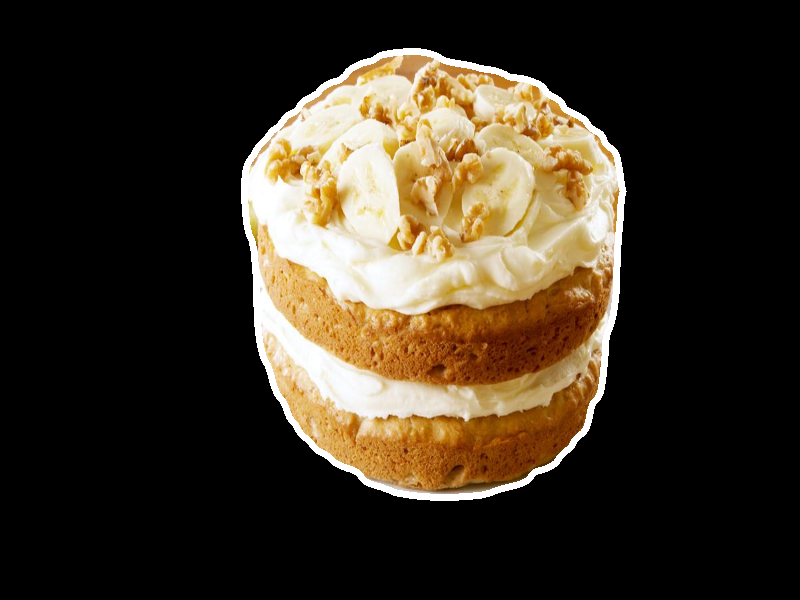

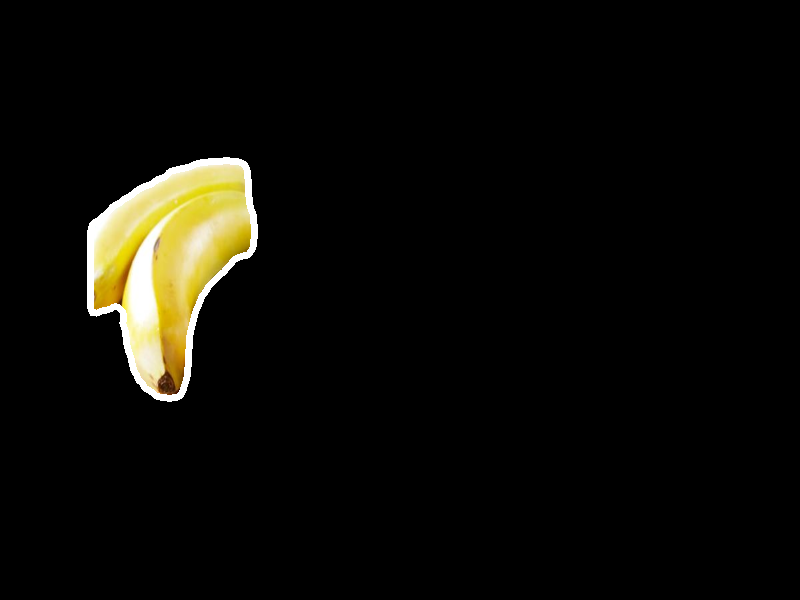

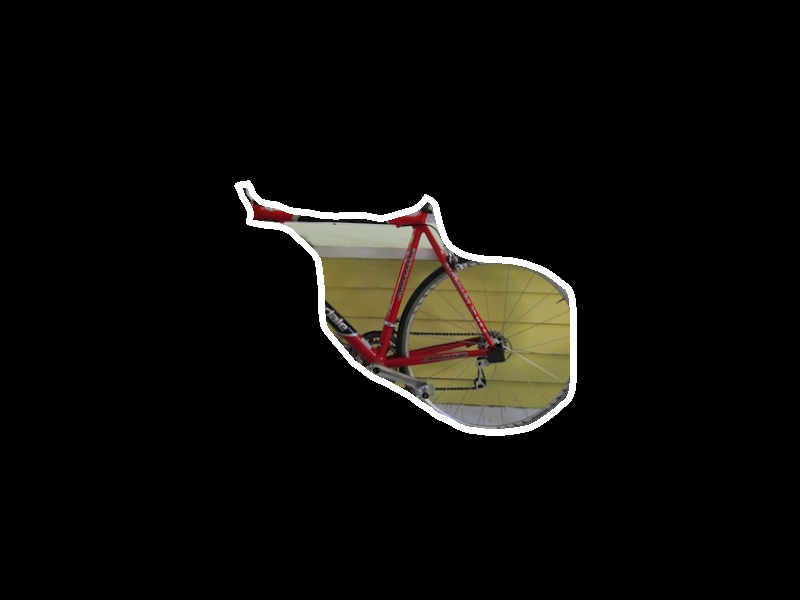

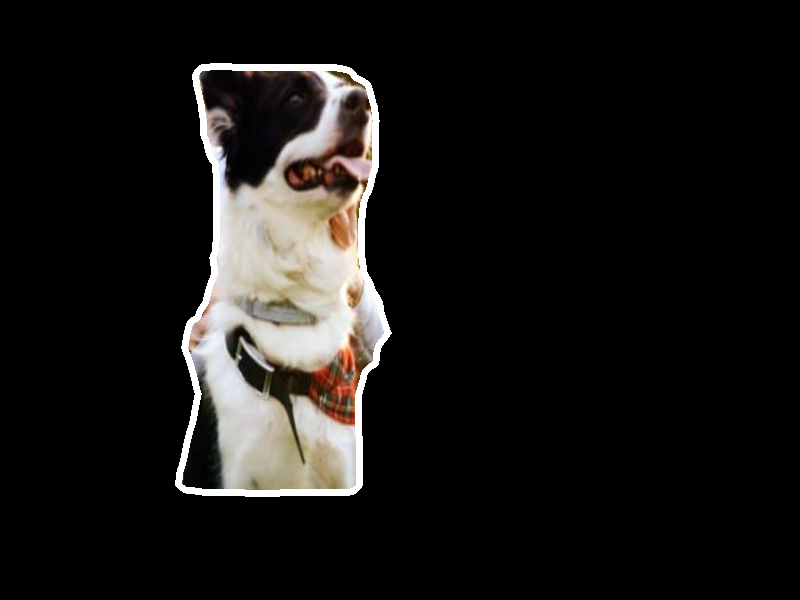

In [295]:
for i in img_list:
    cv2_imshow(i)
    print()

In [296]:
for i in range(len(img_list)):
    tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
    _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
    (x, y, w, h, area) = stats[1]

    m = np.float32([[1, 0, -x], [0, 1, -y]])

    img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))

    if i == 0:
        if area / img_size > 1/ 2:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 3:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 6:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 20:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.9, fy=0.9, interpolation=cv2.INTER_AREA)
        else:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    elif i == 1:
        if area / img_size > 1/ 2:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.55, fy=0.55, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 3:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.65, fy=0.65, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 6:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 20:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.85, fy=0.85, interpolation=cv2.INTER_AREA)
        else:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)

    elif i == 2 or i == 3:
        if area / img_size > 1/ 2:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 3:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 6:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1/ 20:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)
        else:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    else:
        if area / img_size >= 1 / 2:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 3:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 6:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 10:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 15:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        elif area / img_size > 1 / 20:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
        elif area / img_size < 1 / 30:
            img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)

    
        

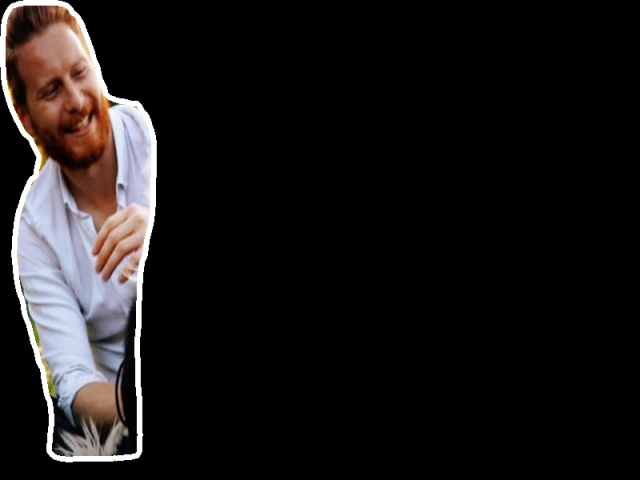

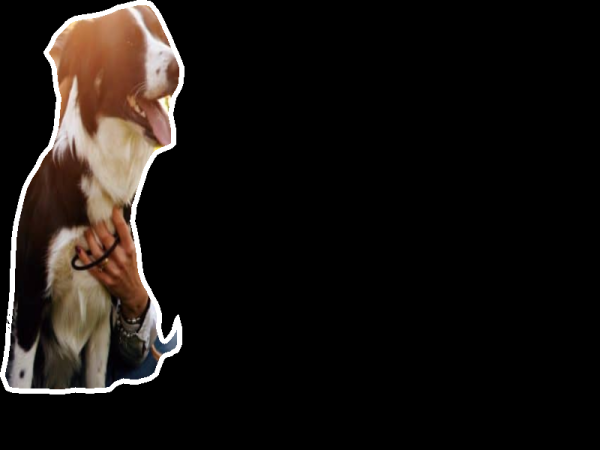

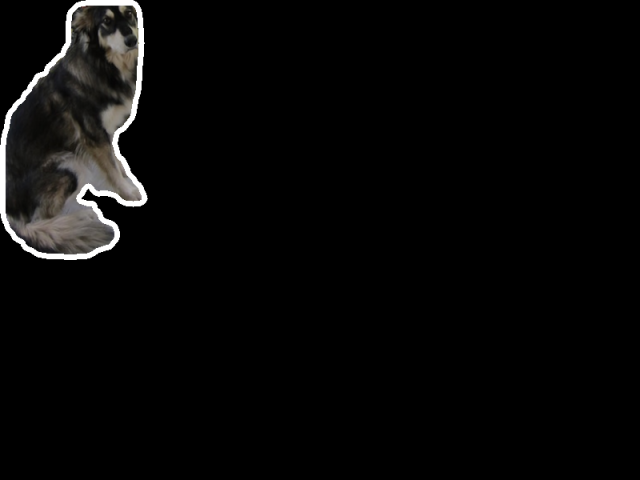

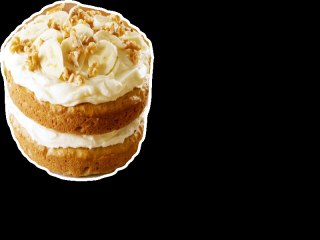

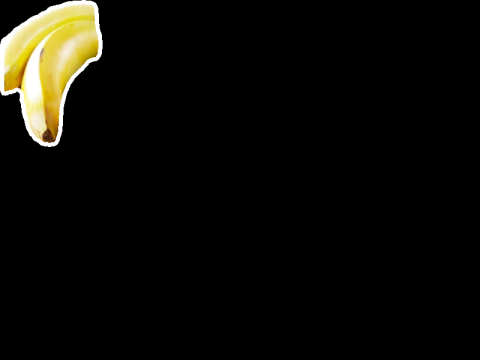

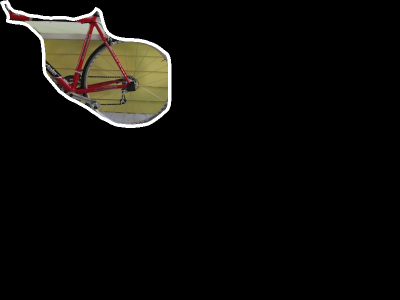

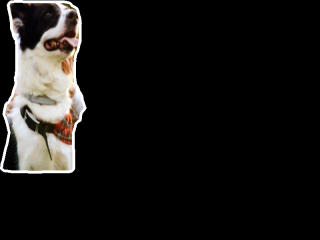

In [297]:
for i in img_list:
    cv2_imshow(i)
    print()

In [298]:
# print(len(img_list))
del img_list[-1]
del img_list[-1]
print(len(img_list))

5


In [299]:
heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart.jpg", cv2.IMREAD_COLOR)
heart_img = cv2.resize(heart_img, (800, 600))

if len(img_list) != 6:
    heart_img_copy = heart_img.copy()

    tmp = cv2.cvtColor(heart_img, cv2.COLOR_BGR2GRAY)
    _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

    # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

    area_sum = 0

    for i in range(1, cnt):
        (x, y, w, h, area) = stats[i]
        area_sum += area

    if area_sum / img_size >= 1 / 2:
            heart_img = cv2.resize(heart_img, (None, None), fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size > 1 / 3:
        heart_img = cv2.resize(heart_img, (None, None), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size > 1 / 6:
        heart_img = cv2.resize(heart_img, (None, None), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size > 1 / 10:
        heart_img = cv2.resize(heart_img, (None, None), fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size > 1 / 15:
        heart_img = cv2.resize(heart_img, (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size > 1 / 20:
        heart_img = cv2.resize(heart_img, (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
    elif area_sum / img_size < 1 / 30:
        heart_img = cv2.resize(heart_img, (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)

      
        
    # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    img_list.append(heart_img)


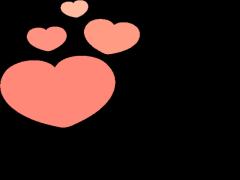

In [300]:
cv2_imshow(heart_img)

In [301]:
# u = np.full((20, 20), 0, np.uint8)
# i = np.full((10, 20), 10, np.uint8)

# u[:i.shape[0], :i.shape[1]] = i[:]
# print(u, "\n")

# u = np.full((10, 10), 0, np.uint8)
# i = np.full((20, 20), 10, np.uint8)

# u[:u.shape[0], :u.shape[1]] = i[:u.shape[0], :u.shape[1]]
# print(u)

In [302]:
for i in range(len(img_list)):
    bg = np.zeros((height, width, 3), dtype=np.uint8)

    if img_list[i].shape[0] > bg.shape[0]:
        bg[:bg.shape[0], :bg.shape[1]] = img_list[i][:bg.shape[0], :bg.shape[1]]
    else:
        bg[:img_list[i].shape[0], :img_list[i].shape[1]] = img_list[i]

    img_list[i] = bg

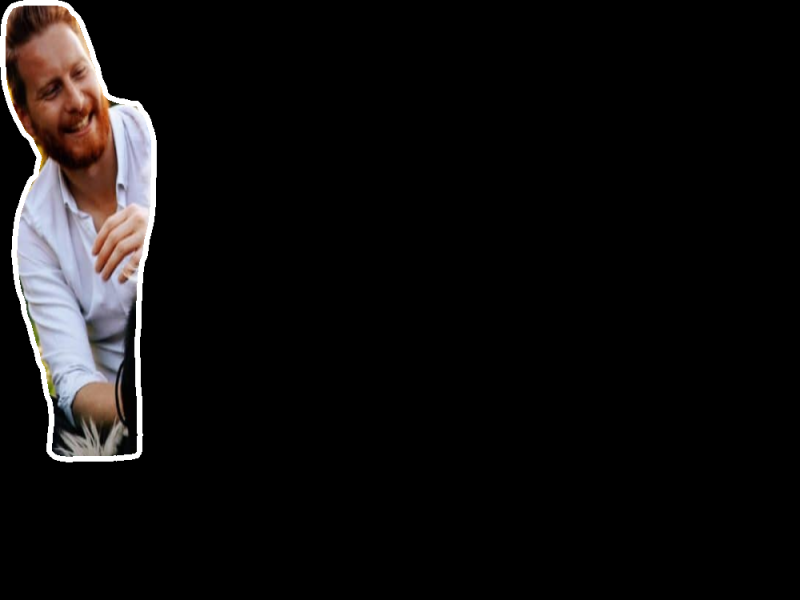

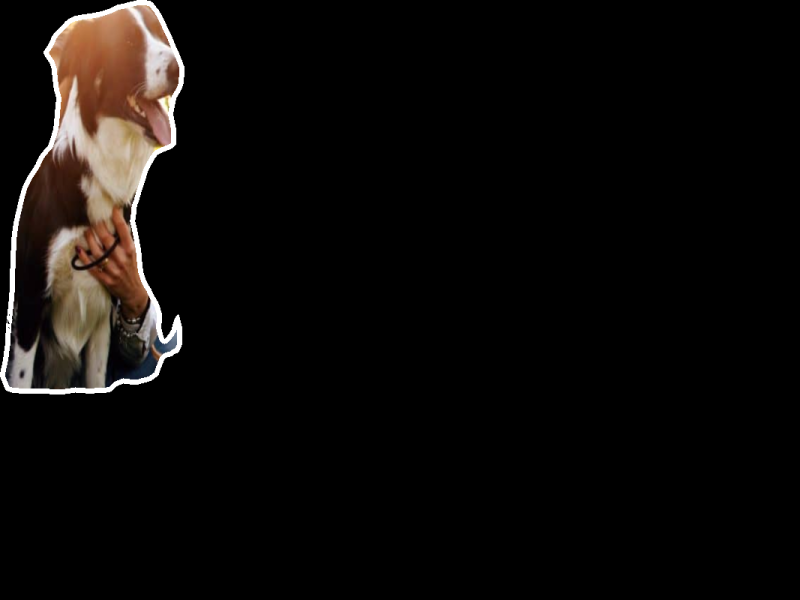

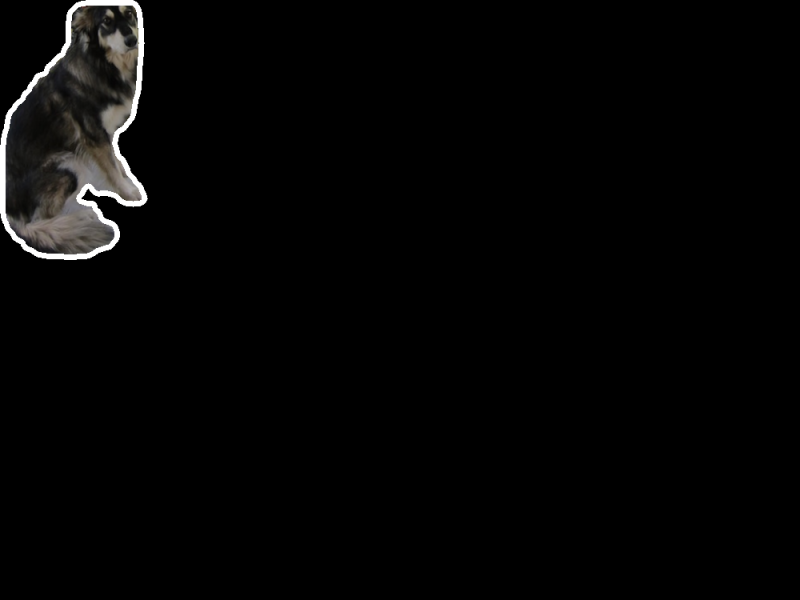

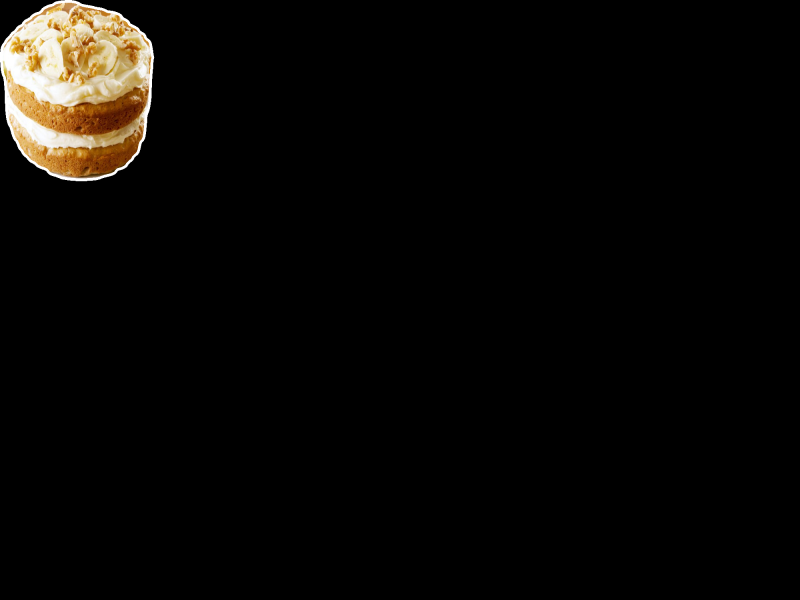

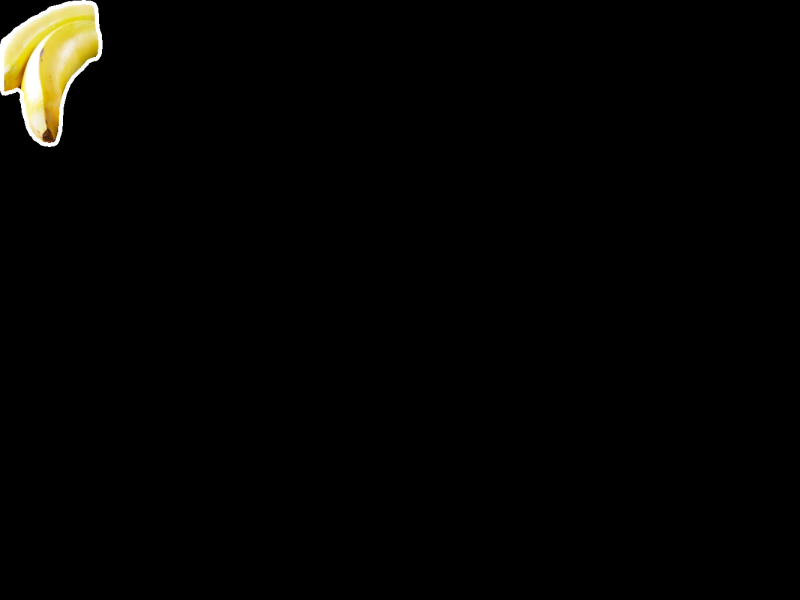

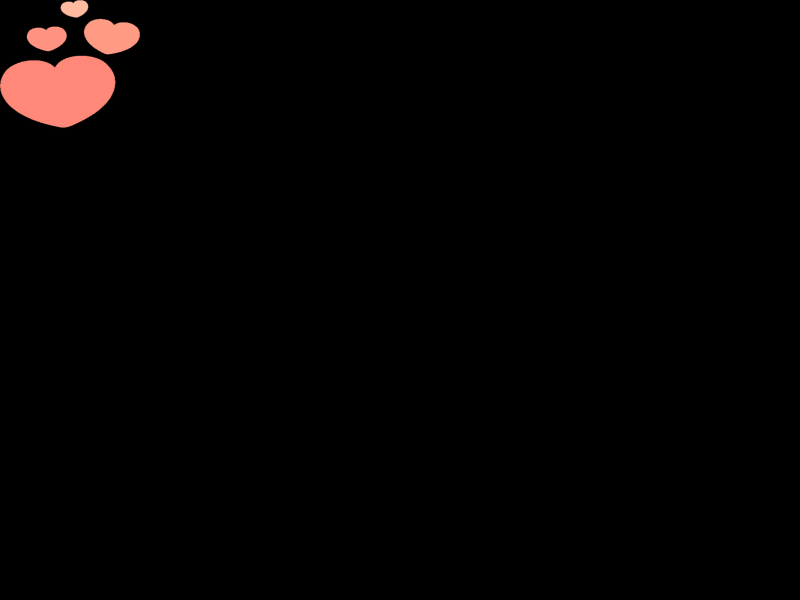

In [303]:
for i in img_list:
    cv2_imshow(i)
    print()

In [304]:
pos_dic = {}

for i in range(len(img_list)):
    tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
    _, tmp = cv2.threshold(tmp, 1, 255, cv2.THRESH_BINARY)

    cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
    centroids = centroids.astype(np.int64)
    (x, y, w, h, area) = stats[1]
    pos_dic[i] = [x, y, w, h, area, (centroids[1][0], centroids[1][1])]

    if i == 0:
        shift_x = 10
        shift_y = height - h

    elif i == 1:
        shift_x = width - w - 10
        shift_y = height - h
    
    elif i == 2:
        shift_x = pos_dic[0][2] + 10
        shift_y = height - pos_dic[0][3] - int(h / 3)

    elif i == 3:
        shift_x = width - w - 10
        shift_y = height - pos_dic[1][3] - h - 10

    else:
        if i == 4:
            shift_x = 20
            shift_y = 20
        else:
            # shift_x = pos_dic[0][2] + pos_dic[2][2] + 20
            # shift_x = (pos_dic[2][2] + pos_dic[4][2]) * int(1 + i / 10)
            shift_x = int(width / (15 - i) * i)
            # shift_y = pos_dic[i - 1][3] - int(pos_dic[i][3] / 2)
            shift_y += int(pos_dic[i][3] / 3)


    m = np.float32([[1, 0, int(shift_x)], [0, 1, int(shift_y)]])
    img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))



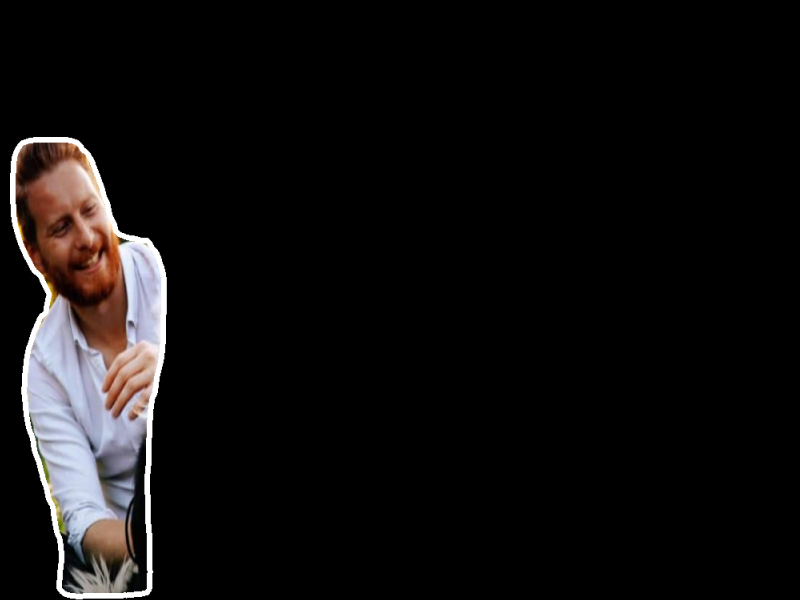

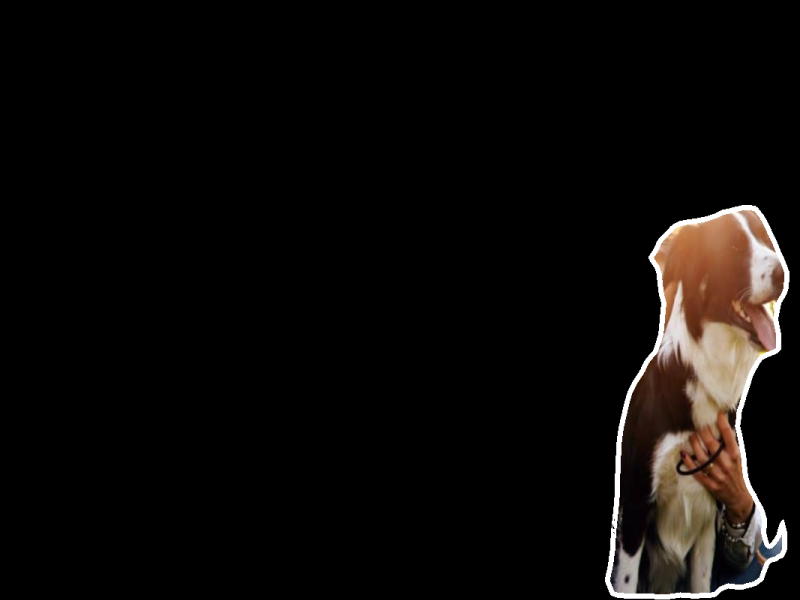

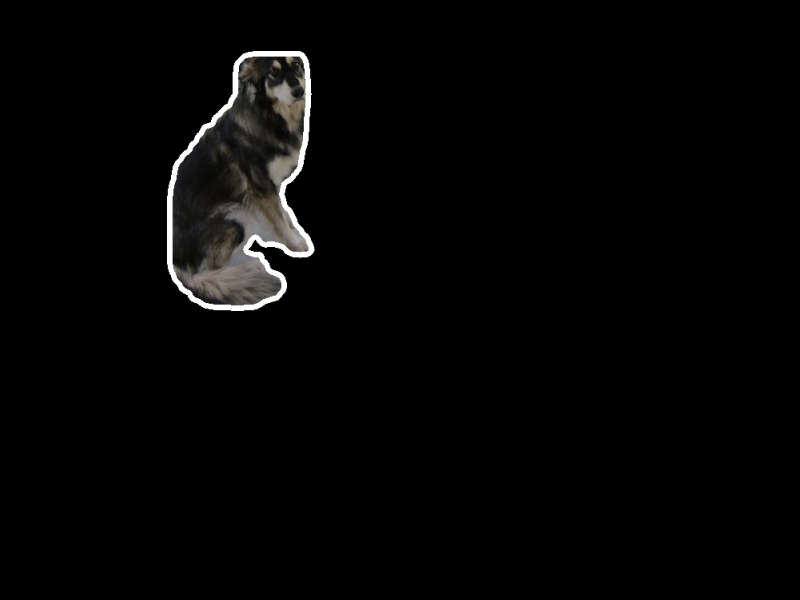

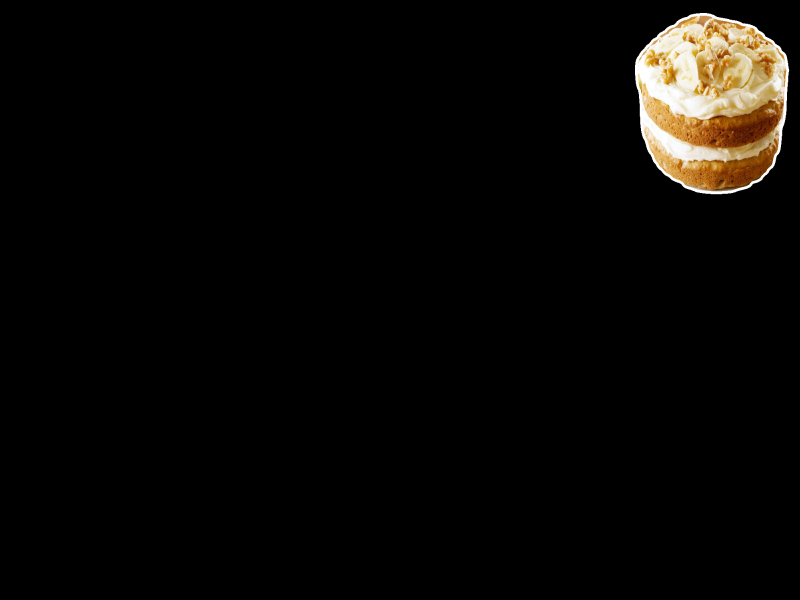

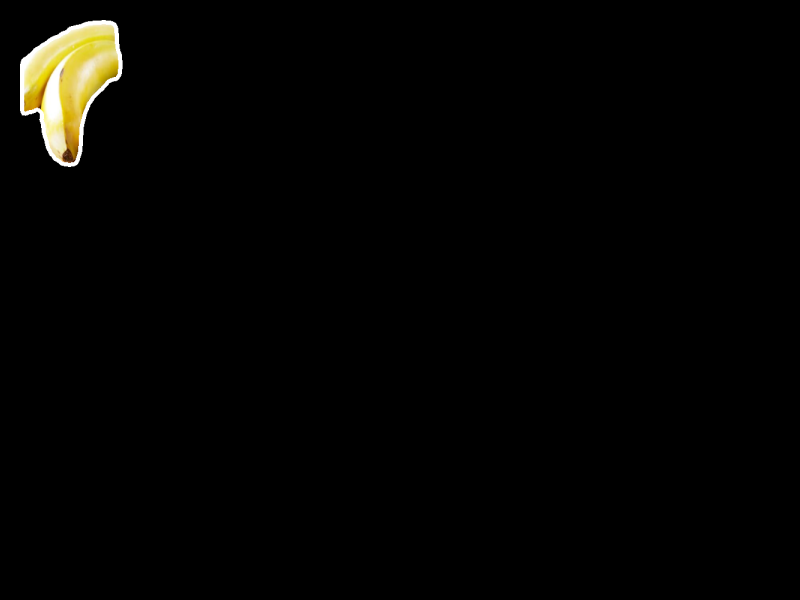

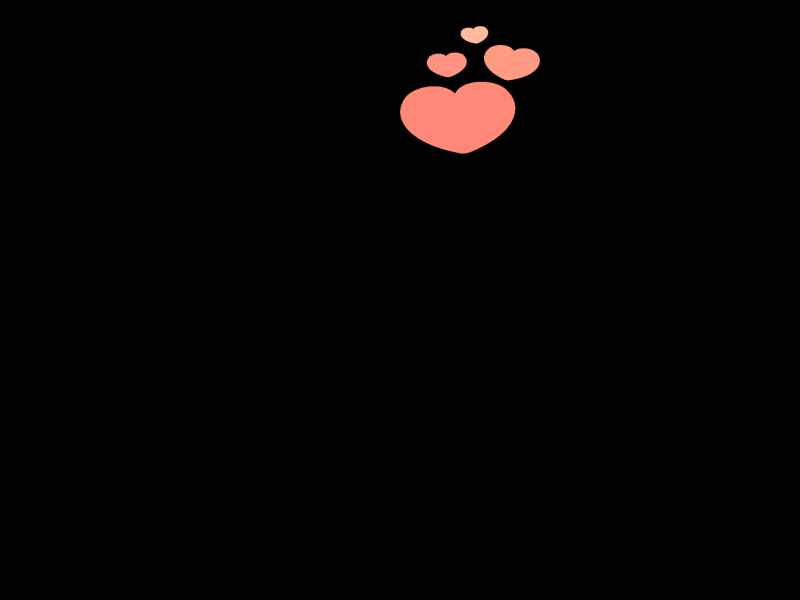

In [305]:
for i in img_list:
    cv2_imshow(i)
    print()

In [306]:
bg_color = {"sky": cv2.merge([np.full((height, width), 255, np.uint8), np.full((height, width), 204, np.uint8), np.full((height, width), 153, np.uint8)]),
            "pink": cv2.merge([np.full((height, width), 255, np.uint8), np.full((height, width), 51, np.uint8), np.full((height, width), 255, np.uint8)]),
            "red": cv2.merge([np.full((height, width), 0, np.uint8), np.full((height, width), 0, np.uint8), np.full((height, width), 255, np.uint8)]),
            }
dst1 = bg_color["sky"]
dst2 = np.zeros((height, width, 3), np.uint8)

In [307]:
for i in img_list[::-1]:
    # dst2 = cv2.add(dst2, i)
    # dst2 = cv2.bitwise_or(dst2, i)

    gray_tmp = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_tmp, 0.1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    masked_fg = cv2.bitwise_and(i, i, mask=mask)
    masked_bg = cv2.bitwise_and(dst2, dst2, mask=mask_inv)

    dst2 = masked_fg + masked_bg


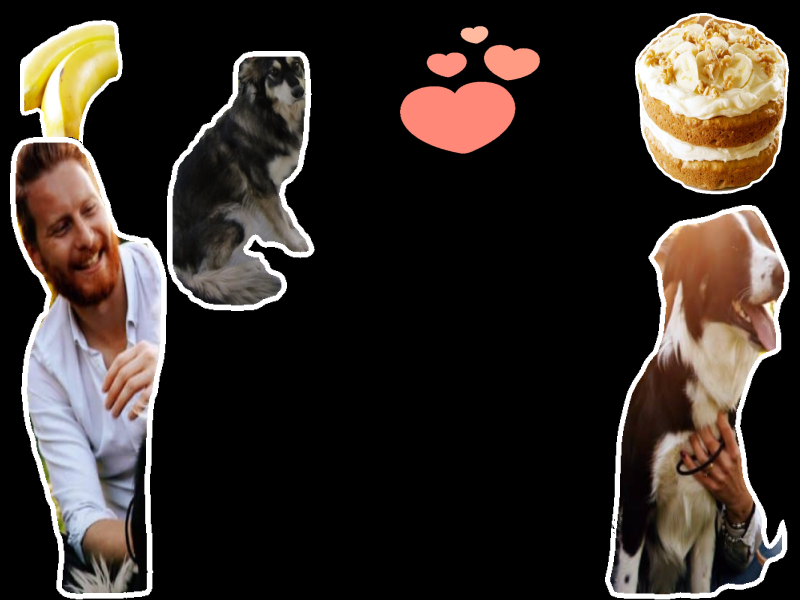

In [308]:
cv2_imshow(dst2)

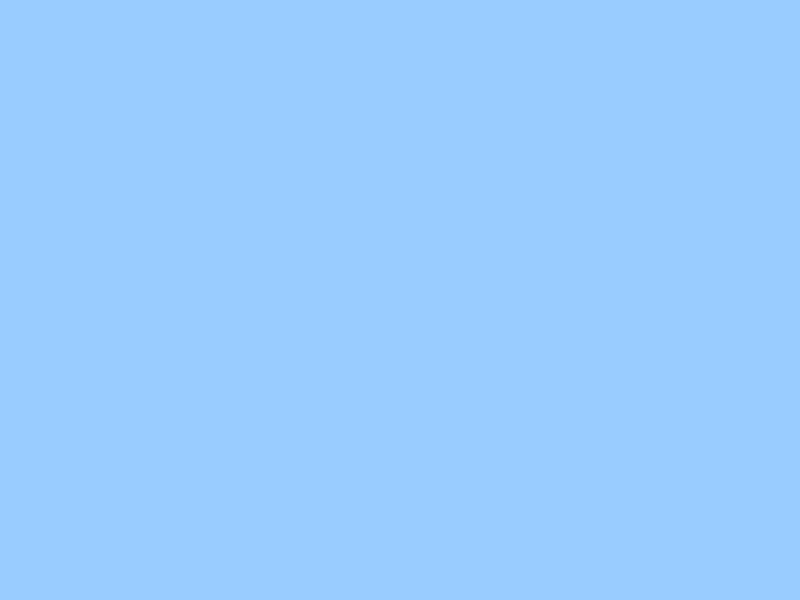

In [309]:
cv2_imshow(dst1)

In [328]:
dst2_gray = cv2.cvtColor(dst2, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(dst2_gray, 0.1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

masked_fg = cv2.bitwise_and(dst2, dst2, mask=mask)
masked_bg = cv2.bitwise_and(dst1, dst1, mask=mask_inv)
dst = masked_fg + masked_bg
# dst = dst2 + masked_bg

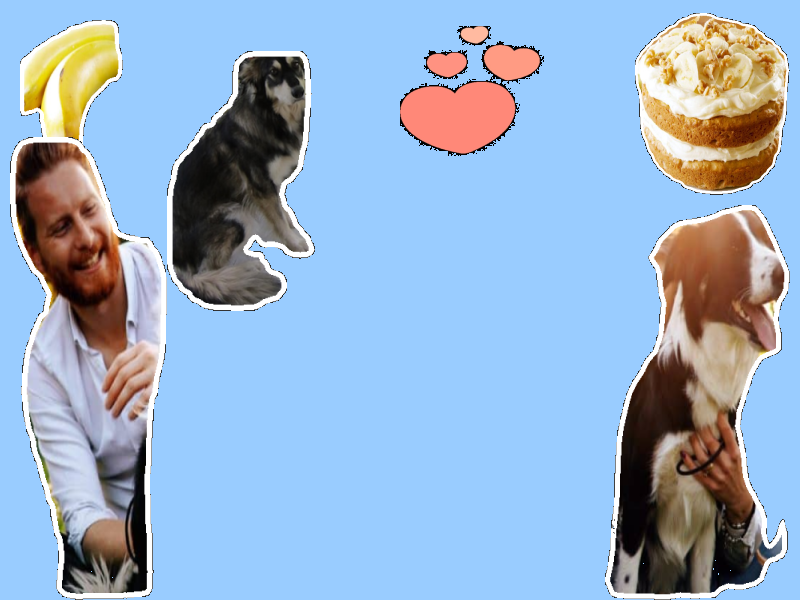

In [329]:
cv2_imshow(dst)

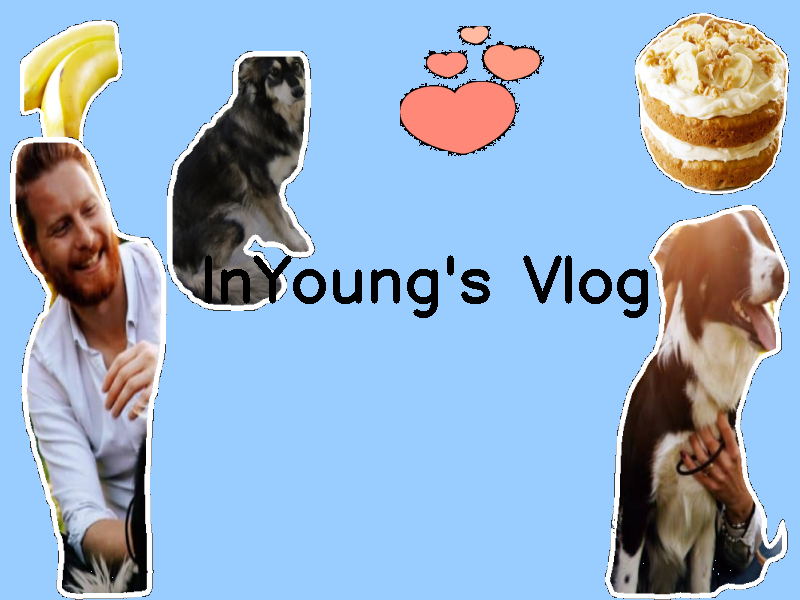

In [330]:
text_color = {"black": (0, 0, 0), "red": (0, 0, 255), "blue": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}
cv2.putText(dst, "InYoung's Vlog", (width // 2 - 200, height // 2), cv2.FONT_ITALIC, 2, text_color["black"], 5)
cv2_imshow(dst)

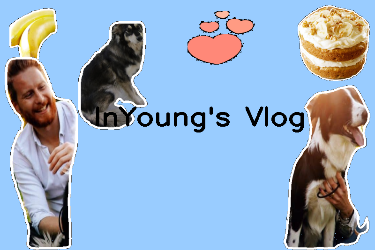

In [331]:
dst = cv2.resize(dst, (375, 250))
cv2_imshow(dst)